# Field Mapping Code: Clustering Approach Demonstration Notebook

This notebook walks through the different processing steps necessary to load Sentinel-2 data (from raw zipped .SAFE files or from a prepared sample dataset) and analyze the imagery through two workflows: Clustering and Thresholding. The core functions are stored in the fields_functions.py file, which references a file with global parameters, the global_config.py file, that stores parameters in a dictionary. Refer to that file to see what each parameter controls. Changing parameters can be done interactively in this notebook by reassigning new values to the parameter, such as: `config['prep_file_dir'] = 'path/to/directory/with/sentinel/tiles/'` 

Since there are multiple ways to load and process data, this notebook should not be run sequentially in full. The first step is loading the data. This can be done by using the `prep_data()` function to load data from a directory of zipped .SAFE Sentinel-2 L2A tiles. Since these tiles are large (about 1 GB per tile), the data is not directly available with the code. In order to enable testing of the analysis code, we have provided a sample dataset as part of thie repo. To load that, run the cell under the "Load Sample Data" heading.

NOTE: In addition to the text description, most of the code is commented for clarity.

### Import packages

First, check the contents of the current working directory to make sure the python files with the functions and global parameters are accessible. Then, load import the fields_functions.py file. The config parameters are stored in the global_config.py, imported at the top of the fields_functions.py along with all the packages necessary for processing. 

In [1]:
import os
from glob import glob
from pprint import pprint
%matplotlib inline

cwd = os.getcwd()
print(cwd)

py_files = glob('*.py')
print(py_files)

/content
[]


In [ ]:
### Import fields functions
from fields_functions import *

### Packages for some plotting to view outputs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

## Connect to the Copernicus Hub API

We will not use the Graphical User Interface from the Copernicus Open Access Hub as we want something fully automated, so we will use the API instead.

We will use the SentinelAPI: https://sentinelsat.readthedocs.io/en/latest/api_overview.html

In [ ]:
#Enter your username and password
username = config["username"]
password = config['password']

api = SentinelAPI('ludiusvox','Gmoney300@', "https://scihub.copernicus.eu/dhus")

Let's take a look at the config parameters. The prefix for each parameter refers to the step in the processing workflow that corresponds with the parameters. For more detail about what each parameter controls, refer to the global_config.py file

In [ ]:
### We can change a parameter in the config dictionary by assigning it directly as so:
config['prep_base_chunk'] = 500

print(config)

{'prep_file_dir': '/Data/SatData', 'prep_tile_id': 'UEB', 'prep_base_chunk': 500, 'prep_time_chunk': 'auto', 'prep_remove_overlap': False, 'prep_manual_subset': True, 'prep_x_start': 7500, 'prep_y_start': 7500, 'prep_step': 500, 'prep_cloud_coverage_thresh': 50, 'prep_load_cloud_mask': True, 'prep_apply_cloud_mask': True, 'prep_cloud_mask_thresh': 70, 'prep_clip_outliers': True, 'prep_clip_percentile': 1, 'prep_normalize_bands': True, 'username': 'ludiusvox', 'password': 'Gmoney300@', 'preproc_out_dir': '/home/preproc_out_dir/', 'preproc_outfile_prefix': 'fields_preproc_demo_', 'preproc_sample_pct': 0.05, 'preproc_n_clusters': 15, 'preproc_cluster_tile': True, 'kmeans_n_clusters': 15, 'kmeans_model_out_dir': 'kmeans_model_dir/', 'kmeans_8var_clusters': True, 'kmeans_std_thresh': 0.2, 'kmeans_min_thresh': 0, 'kmeans_max_thresh': 0.3, 'kmeans_range_thresh': 0.7, 'kmeans_ndwi_thresh': 0.2, 'kmeans_mask_out_dir': 'mask_out_dir/', 'kmeans_from_full_tile_mask': False, 'seg_rgb_date_str': '20

### Changing global parameters
You can update the config dictionary interactively, too. Here, we change the base chunk size parameter. We can do this with any of the paramters within our notebook so that we do not have to change the global_config.py file directly.

### Loading data

The prep_data() function expects the `'prep_data_dir'` parameter in the config dictionary to have zipped Sentinel-2 L2A tiles. L2A tiles have been preprocessed to estimate bottom of atmosphere pixel values, correcting for atmospheric aerosols. The metadata for L1C data is apparently structured differently and does not work with the GDAL function to read the tile info.

Alternative from the original EveryField repo that we will not use it was written: 
"If you do not have access to the full set of Sentinel-2 tiles, you can skip the prep_data() function call and load a sample of the data found in the google drive project folder here: https://drive.google.com/drive/folders/1n2tzO8I6EZQdkYzcB8L9omVsQDsb8eEh?usp=sharing

The sample data comes in four versions for an area in NW Minnesota from the T14TPT tile during the 2019 groing season: 500x500 pixels with and without cloud mask applied, and 1000x1000 pixel with and without cloud mask applied. 

To load the sample data, download the version of interest and fill in the sample_data_fp variable to point to where it is saved locally. Skip the next cell and run the cell to load the netCDF file directly into xarray. This should enable you to run the rest of the demo code."

In our case for Poland, we will use directly zipped Sentinel-2 L2A tiles and the prep_data() module right after.

### Download L2A tiles

Sentinel images (aka data cubes) are called tiles and can be downloaded directly from the Copernicus Hub. The only thing which is needed is a shapefile of Area of Interest (aoi) to find the corresponding tile. In our case, we are interested in the full country of Poland which is our aoi. Luckily a shapefile for Poland can be found here: https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/poland-shapefile

For our purpose, we will use the shapefile where the Poland area is devided in 10km squares area as illustrated below:

![pl_10km](pl_10km.png)

It is not perfect and we may need to remove squares which are 100% sea and which do not belong to Poland but the neigbhour countries.

In this demo, we will work only with one random selected square from this grid. As we do not know which squares are land or sea, we will first visualize the random selected square first. If it is land, we will use a seed to fix it for the demo, if it is sea we run the random selection again until we find land.

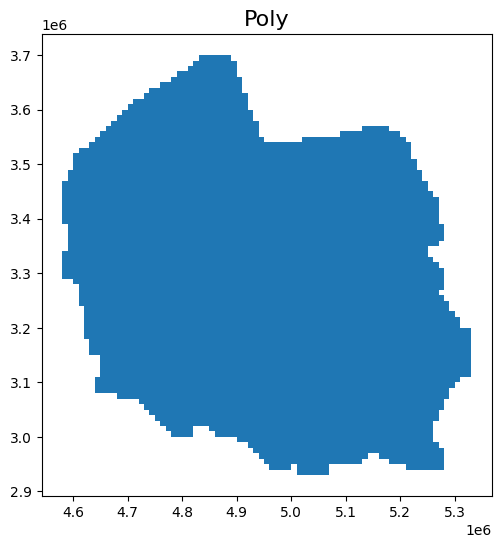

In [ ]:
# Plot the shapefile
poly = gpd.read_file("pl_10km.shp") # previously "POLYGON.shp"
fig, ax = plt.subplots(figsize=(6, 6))

poly.plot(ax=ax)

ax.set_title("Poly",
             fontsize=16)
plt.show()

In [ ]:
# Load shape file
shapefile_all = gpd.read_file("pl_10km.shp")
# Explore:
print(shapefile_all.head())
print(shapefile_all.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((4580000.000 3290000.000, 4580000.000...  
1  POLYGON ((4580000.000 3300000.000, 4580000.000...  
2  POLYGON ((4580000.000 3310000.000, 4580000.000...  
3  POLYGON ((4580000.000 3320000.000, 4580000.000...  
4  POLYGON ((4580000.000 3330000.000, 4580000.000...  
epsg:3035


The coordinate system is epsg:3035 and will need to be converted it to epsg:4326 for the SentinelAPI call. We also need to convert the shapefile to GeoJSON.

In [ ]:
# change CRS to epsg 4326
shapefile_all_transformed = shapefile_all.to_crs(epsg=4326)
print(shapefile_all_transformed.head())
print(shapefile_all_transformed.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((13.82950 52.65766, 13.83735 52.74738...  
1  POLYGON ((13.83735 52.74738, 13.84523 52.83710...  
2  POLYGON ((13.84523 52.83710, 13.85316 52.92682...  
3  POLYGON ((13.85316 52.92682, 13.86112 53.01653...  
4  POLYGON ((13.86112 53.01653, 13.86913 53.10625...  
EPSG:4326


Now let's select one random square of land aoi for the future call to the SentinelAPI:

In [ ]:
# select a random square for demo (I ran it twice and found a land square aoi so I fixed the seed for the demo)
from random import seed, randrange
seed(105)
rowid = randrange(0,shapefile_all_transformed.shape[0])
shapefile = shapefile_all_transformed.iloc[[rowid]]
# Explore:
print(shapefile.head())

          CELLCODE  EOFORIGIN  NOFORIGIN  \
3596  10kmE520N315    5200000    3150000   

                                               geometry  
3596  POLYGON ((22.53357 50.78160, 22.55766 50.86997...  


In [ ]:
# check that the conversion worked
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Convert shapefile to GeoJSON as this is the format needed for the api
shapefile.to_file('POLYGON_POL_converted.geojson', driver='GeoJSON')

In [ ]:
# Define the path to your AOI - Must be a Geojson shapefile
footprint = geojson_to_wkt(read_geojson("POLYGON_POL_converted.geojson"))
print(footprint)

GEOMETRYCOLLECTION(POLYGON((22.5336 50.7816,22.5577 50.8700,22.6979 50.8545,22.6736 50.7662,22.5336 50.7816)))


To be sure that we have a squre on land, lets plot it with folium, we need first to give the longitude and latitude where the map should be centered to show our square of interest. We will take the first coordinate:

In [ ]:
for index, row in shapefile.iterrows():
     for pt in list(row['geometry'].exterior.coords):
        long = Point(pt).x
        lat = Point(pt).y
        print(long,lat)
        break

22.533568131029224 50.781600452000475


In [ ]:
# Interactive visualization of polygon using the library folium
m = folium.Map([lat, long], zoom_start=11) # starting coordinate: latitude and longitude of Lubola, Poland
boundary = gpd.read_file(r'POLYGON_POL_converted.geojson')
folium.GeoJson(boundary).add_to(m)
m

The aoi is land, we are good to go with the API.

In [ ]:
# Define the sentinel products we need
# Not too much data to start as we will download it locally and those images are massive in size (will take disk space and time to download)
# Here we will be looking with a Descending orbit direction from May to October 2022 (harvest months) Sentinel-2 Hyperspectral (Level-2A) with any cloud coverage for now.
start_date = '20220501'
stop_date = '20221031'
products = api.query(footprint,
                     date = (start_date,stop_date),
                     platformname='Sentinel-2',
                     processinglevel = 'Level-2A',
                     orbitdirection='DESCENDING') # cloudcoverpercentage=(0, 30)
# Download all products 
gdf = api.to_geodataframe(products)
gdf.head(3)

Querying products:  72%|#######2  | 100/138 [00:00<?, ?product/s]

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
d29b8235-8955-404f-9e85-04f7ea1068ce,S2B_MSIL2A_20221028T093039_N0400_R136_T34UFB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-10-28T09:30:39.024Z, Instrument: MS...",false,2022-10-28 11:01:29,2022-10-28 09:30:39.024,2022-10-28 09:30:39.024,2022-10-28 18:56:14.784,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20221028T110129_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20221028T110129_A0294...,S2B_MSIL2A_20221028T093039_N0400_R136_T34UFB_2...,d29b8235-8955-404f-9e85-04f7ea1068ce,"MULTIPOLYGON (((23.95387 50.42629, 24.01703 51..."
f3c64a00-79dc-47e7-b0f5-e8570a4f4a98,S2B_MSIL2A_20221028T093039_N0400_R136_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-10-28T09:30:39.024Z, Instrument: MS...",false,2022-10-28 11:01:29,2022-10-28 09:30:39.024,2022-10-28 09:30:39.024,2022-10-28 18:48:56.124,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20221028T110129_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20221028T110129_A0294...,S2B_MSIL2A_20221028T093039_N0400_R136_T34UEB_2...,f3c64a00-79dc-47e7-b0f5-e8570a4f4a98,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51..."
e52c55b6-1963-49ab-ae96-31ff645a4faa,S2A_MSIL2A_20221026T094101_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-10-26T09:41:01.024Z, Instrument: MS...",false,2022-10-26 14:51:55,2022-10-26 09:41:01.024,2022-10-26 09:41:01.024,2022-10-26 16:46:30.250,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_ATOS_20221026T145155_S2022...,S2A_OPER_MSI_L2A_TL_ATOS_20221026T145155_A0383...,S2A_MSIL2A_20221026T094101_N0400_R036_T34UEB_2...,e52c55b6-1963-49ab-ae96-31ff645a4faa,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51..."


In [ ]:
# create some new columns wiht the tileidentifier (5 letter and number), the month and the date seperately
def extract_tileID(x):
    return x[5]
    
gdf['tileidentifier'] = gdf['title'].str.split("_").apply(extract_tileID)
gdf['generationdateonly'] = pd.DatetimeIndex(gdf['generationdate']).date
gdf['generationmonthonly'] = pd.DatetimeIndex(gdf['generationdate']).month

# sort with less cloud coverage possible
gdf_sorted = gdf.sort_values(['tileidentifier', 'generationdate', 'cloudcoverpercentage'], ascending=[True,True,True])

gdf_sorted.head(3)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry,tileidentifier,generationdateonly,generationmonthonly
0334f2ee-5eb0-4963-9893-d36af97d9087,S2B_MSIL2A_20220501T093029_N0400_R136_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-01T09:30:29.024Z, Instrument: MS...",false,2022-05-01 11:36:59,2022-05-01 09:30:29.024,2022-05-01 09:30:29.024,2022-05-01 16:30:28.615,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220501T113659_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220501T113659_A0269...,S2B_MSIL2A_20220501T093029_N0400_R136_T34UEB_2...,0334f2ee-5eb0-4963-9893-d36af97d9087,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-05-01,5
e6d3a18b-134a-4bda-8ed9-c438a34416fd,S2B_MSIL2A_20220504T094029_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-04T09:40:29.024Z, Instrument: MS...",false,2022-05-04 12:47:44,2022-05-04 09:40:29.024,2022-05-04 09:40:29.024,2022-05-04 18:18:13.087,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220504T124744_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220504T124744_A0269...,S2B_MSIL2A_20220504T094029_N0400_R036_T34UEB_2...,e6d3a18b-134a-4bda-8ed9-c438a34416fd,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-05-04,5
b6c2f079-9519-4b14-a460-4a32327fd00d,S2A_MSIL2A_20220506T093041_N0400_R136_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-06T09:30:41.024Z, Instrument: MS...",false,2022-05-06 15:32:14,2022-05-06 09:30:41.024,2022-05-06 09:30:41.024,2022-05-06 18:07:47.227,...,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_ATOS_20220506T153214_S2022...,S2A_OPER_MSI_L2A_TL_ATOS_20220506T153214_A0358...,S2A_MSIL2A_20220506T093041_N0400_R136_T34UEB_2...,b6c2f079-9519-4b14-a460-4a32327fd00d,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-05-06,5


In [ ]:
# check that we have the 6 harvest month for at least one tile
gdf_sorted.groupby(['tileidentifier','generationmonthonly']).count()

title  link  link_alternative  link_icon  \
tileidentifier generationmonthonly                                             
T34UEB         5                       13    13                13         13   
               6                       12    12                12         12   
               7                       12    12                12         12   
               8                       10    10                10         10   
               9                       10    10                10         10   
               10                      12    12                12         12   
T34UFB         5                       13    13                13         13   
               6                       12    12                12         12   
               7                       12    12                12         12   
               8                       10    10                10         10   
               9                       10    10                10         10   
               10                      12    12                12         12   

                                    summary  ondemand  generationdate  \
tileidentifier generationmonthonly                                      
T34UEB         5                         13        13              13   
               6                         12        12              12   
               7                         12        12              12   
               8                         10        10              10   
               9                         10        10              10   
               10                        12        12              12   
T34UFB         5                         13        13              13   
               6                         12        12              12   
               7                         12        12              12   
               8                         10        10              10   
               9                         10        10              10   
               10                        12        12              12   

                                    beginposition  endposition  ingestiondate  \
tileidentifier generationmonthonly                                              
T34UEB         5                               13           13             13   
               6                               12           12             12   
               7                               12           12             12   
               8                               10           10             10   
               9                               10           10             10   
               10                              12           12             12   
T34UFB         5                               13           13             13   
               6                               12           12             12   
               7                               12           12             12   
               8                               10           10             10   
               9                               10           10             10   
               10                              12           12             12   

                                    ...  platformidentifier  orbitdirection  \
tileidentifier generationmonthonly  ...                                       
T34UEB         5                    ...                  13              13   
               6                    ...                  12              12   
               7                    ...                  12              12   
               8                    ...                  10              10   
               9                    ...                  10              10   
               10                   ...                  12              12   
T34UFB         5                    ...                  13              13   
               6                    ...       

In [ ]:
# In the case we have several tile in the product package, we take only the first one.
gdf_sorted_head = gdf_sorted.groupby(['tileidentifier','generationmonthonly']).head(1)
gdf_sorted_head.head(6)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry,tileidentifier,generationdateonly,generationmonthonly
0334f2ee-5eb0-4963-9893-d36af97d9087,S2B_MSIL2A_20220501T093029_N0400_R136_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-01T09:30:29.024Z, Instrument: MS...",false,2022-05-01 11:36:59,2022-05-01 09:30:29.024,2022-05-01 09:30:29.024,2022-05-01 16:30:28.615,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220501T113659_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220501T113659_A0269...,S2B_MSIL2A_20220501T093029_N0400_R136_T34UEB_2...,0334f2ee-5eb0-4963-9893-d36af97d9087,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-05-01,5
8ca78993-b525-48b5-8764-a73957a19e00,S2B_MSIL2A_20220603T094029_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-06-03T09:40:29.024Z, Instrument: MS...",false,2022-06-03 11:36:02,2022-06-03 09:40:29.024,2022-06-03 09:40:29.024,2022-06-03 14:38:10.580,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220603T113602_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220603T113602_A0273...,S2B_MSIL2A_20220603T094029_N0400_R036_T34UEB_2...,8ca78993-b525-48b5-8764-a73957a19e00,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-06-03,6
e94c30f6-c0c8-49db-9737-7f814217ce47,S2B_MSIL2A_20220703T094039_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-07-03T09:40:39.024Z, Instrument: MS...",false,2022-07-03 11:32:04,2022-07-03 09:40:39.024,2022-07-03 09:40:39.024,2022-07-03 17:41:38.020,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220703T113204_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220703T113204_A0278...,S2B_MSIL2A_20220703T094039_N0400_R036_T34UEB_2...,e94c30f6-c0c8-49db-9737-7f814217ce47,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-07-03,7
296c509b-f12b-4537-9df9-d76591208fe1,S2B_MSIL2A_20220802T093549_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-08-02T09:35:49.024Z, Instrument: MS...",false,2022-08-02 11:26:57,2022-08-02 09:35:49.024,2022-08-02 09:35:49.024,2022-08-02 15:30:34.544,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220802T112657_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220802T112657_A0282...,S2B_MSIL2A_20220802T093549_N0400_R036_T34UEB_2...,296c509b-f12b-4537-9df9-d76591208fe1,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-08-02,8
ffa5a2ce-e526-468b-9ce0-501e594704bf,S2B_MSIL2A_20220901T093549_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-09-01T09:35:49.024Z, Instrument: MS...",false,2022-09-01 11:25:02,2022-09-01 09:35:49.024,2022-09-01 09:35:49.024,2022-09-01 15:16:52.610,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220901T112502_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220901T112502_A0286...,S2B_MSIL2A_20220901T093549_N0400_R036_T34UEB_2...,ffa5a2ce-e526-468b-9ce0-501e594704bf,"MULTIPOLYGON (((22.54644 50.45352, 22.57954 51...",T34UEB,2022-09-01,9
c0864173-7121-404a-9c05-4ffb10239fbd,S2B_MSIL2A_20221001T094029_N0400_R036_T34UEB_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-10-01T09:40:29.024Z, Instrument: MS...",false,2022-10-01 19:56:32,2022-10-01 09:40:29.024,2022-10-01 09:40:29.024,2022-10-0

In [ ]:
print(gdf_sorted_head.shape)

(12, 44)


In [ ]:
# WARNING ensure you have enough disk space for this demo. In my case it took 37.6 GB after a few tests.
# This will download the 6 months of tile T34UFB for the aoi of interest.
# Sometimes, the API is unable to download all the tiles, so we skip the failed download for now.
prep_file_dir = '/Volumes/Data/SatData/downloads'
Path(prep_file_dir).mkdir(exist_ok=True)
for item in gdf_sorted_head["uuid"]:
    corresponding_title = gdf_sorted_head.loc[[item]]['title']
    corresponding_title_zip = corresponding_title.values[0] + ".zip"
    print("corresponding_title_zip",corresponding_title_zip)
    path_file = os.path.join(prep_file_dir, corresponding_title_zip)
    if path.exists(path_file):
        print("file already exits", corresponding_title_zip)
    else:
        try:
            api.download(item, directory_path= prep_file_dir)
        except:
            print(item, "not downloaded")
            pass

corresponding_title_zip S2B_MSIL2A_20220501T093029_N0400_R136_T34UEB_20220501T113659.zip
0334f2ee-5eb0-4963-9893-d36af97d9087 not downloaded
corresponding_title_zip S2B_MSIL2A_20220603T094029_N0400_R036_T34UEB_20220603T113602.zip
8ca78993-b525-48b5-8764-a73957a19e00 not downloaded
corresponding_title_zip S2B_MSIL2A_20220703T094039_N0400_R036_T34UEB_20220703T113204.zip


MD5 checksumming:   0%|          | 0.00/931M [00:00<?, ?B/s]

corresponding_title_zip S2B_MSIL2A_20220802T093549_N0400_R036_T34UEB_20220802T112657.zip
296c509b-f12b-4537-9df9-d76591208fe1 not downloaded
corresponding_title_zip S2B_MSIL2A_20220901T093549_N0400_R036_T34UEB_20220901T112502.zip


MD5 checksumming:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

corresponding_title_zip S2B_MSIL2A_20221001T094029_N0400_R036_T34UEB_20221001T195632.zip
c0864173-7121-404a-9c05-4ffb10239fbd not downloaded
corresponding_title_zip S2B_MSIL2A_20220501T093029_N0400_R136_T34UFB_20220501T113659.zip


# Tasks to discuss with Aaron

Aaron, if I understood properly the idea is to download all the tiles from all the aoi squares from the Poland grid (something to speak about at the next meeting) automatically, correct?

Here are the different tasks pending:
* (A) find which rowid in the shapefile_all object is land or see and remove the 100% sea or 100% neighbour countries squares using their rowid. This can be done visually by plotting a map with overlayed squares with rowid on a plot.
* (B) add a module which can ensure that the tile has all the harvest months available from May to October. The issue is that the API sometimes skip some some tiles and the script needs to be re-run several time to get it all.
* (C) the global variable 'prep_tile_id' need to be dynamic and not static like it is now.
* (D): I got stuck at cell [58] with AttributeError: module 'xarray' has no attribute 'ufuncs'. Even if I set my environnement with the deprecated version of xarray=0.15.1 follwoing the README.md, it seems conda automatically corrected some dependencies issue and force version xarray  2023.1.0 which is the most recent. Of course, ufuncs is deprectaed, so we may have to find a work around.
* (E) Data engineering: setup a AWS EC2 instance to run a python script which will upload and store all tiles from the square grids in a S3 bucket.
* (F) Bonus: eventually thinking about batch processing for donwloading on AWS. 

# Loading data from a directory of zipped Sentinel-2 files and prep the data

In [ ]:
### Loading data from a directory of zipped Sentinel-2 files
### Skip this step if you do not have a directory with Sentinel-2 tiles in it 
### Load the sample data in the cell below instead.

ds_time_stack = prep_data()

WARNING: August did not pass the cloud coverage check and will be missing

### Loading sample data
Here, we will load the prepared sample data for a 500x500 pixel area in northwest Minnesota by reading the netCDF file directly into an xarray dataset. This is the same as the prep_data() output but for a smaller spatial area. When we read in the data with `xr.open_dataset()` be sure to include the `chunks` argument to coerce the data into dask arrays, which enable parallel processing during the analysis steps. Here, we use the `'auto'` argument to allow xarray to automatically assign an appropriate chunk size to each of the three dimensions: x, y, and time.

In [ ]:
### Loading sample data directly from netCDF file

# filepath to the sample data
# sample_data_fp = 'C:/Users/jesse/Documents/grad school/masters research/code/fields_library/thesis_code_cleanup/sample_data/sample_data_TPT_px500_cldcov40_cldmask.nc'
#sample_data_fp = 'sample_data/sample_data_TPT_px500_cldcov40_cldmask.nc'


### In order to utilize parallel processing with dask within xarray, make sure to set a chunk size when reading in the data.
### You can use the keywork 'auto' to have dask automatically set a chunk size based on data size and memory limitations
#ds_time_stack = xr.open_dataset(sample_data_fp, chunks={'x':'auto', 'y':'auto','time':'auto'})
#print(ds_time_stack)

### Visualize a band from the imagery

Let's take a look at the NIR band from one of the time steps in our raster stack. We named this object `ds_time_stack` because it is an xarray Dataset (ds) structure comprised of a stack of 4-band raster imagery across the time period of our study (May - October, 2019). We can use some built-in xarray methods to select the time based on an index value in the time dimension `.isel(time=8)` and select the NIR band via the data variable name `.nir` and then use the `.plot()` method to visualize the band via a matplotlib wrapper function.

In [ ]:
ds_time_stack.isel(time=4).nir.plot(figsize=(8,6))

## Cluster Analysis Workflow

Now that we have the data loaded into our data structure via the `ds_time_stack` object, we can conduct some preprocessing to extract useful data from our raw imagery. In the preprocessing step, we compute the monthly median NDVI values, the mean NDWI values, and the standard deviation of NDVI over time for each pixel. These data get saved to a separate netCDF file. The variables produced in this preprocessing step can be customized in the `preprocess_to_netcdf()` function in the fields_functions.py file. These preprocessed data layers then get passed to a K-Means clustering algorithm to identify clusters of similar pixels based on the preprocessed temporal data inputs. The cluster centers for each chunk processed get saved out to separate files, then later we cluster all the sampled data and classify the clusters into crop or non-crop classes to create a crop mask.

Let's walk through what is happening in the `preprocess_to_netcdf()` function. The layers that are created in this step can be edited, but this will cause errors downstream in the processing workflow based on how the code is currently structured. 

The first step is to define input parameters from the global config file.

In [ ]:
### This function combines all the preprocessing steps and saves out netcdf files. 
### It also restructures the data and fits a k-means clustering model to the data, saving out the cluster centers to a separate directory.
### A larger number of analyitcal layers were processed initially, but were ultimately commented out of the function.
### Only the layers used for the clustering are computed and saved to netcdf.
### Once all the tiles have been preprocessed, they can be easily opened in xarray with xr.open_mfdataset()
# def preprocess_to_netcdf(ds_time_stack):
#     global config      


out_dir = config['preproc_out_dir']
out_file_name = config['preproc_outfile_prefix'] + config['prep_tile_id']
sample_pct = config['preproc_sample_pct']
n_clusters = config['preproc_n_clusters']
cluster_tile = config['preproc_cluster_tile']

Next we can start to calculate secondary layers based on the raw data of the raster data in our ds_time_stack object. First, let's look at how many valid, cloud free observations there are for each pixel across the time stack by counting the number of non-null pixels over the time dimension.

By visualizing the outputs, we can see what areas are masked out by the cloud mask more over the growing season. We can see a few dark spots on the left side indicating features that do not have many valid observations. Since it is not likely that those specific points are cloudy in every image, this is probably the result of a misclassification of the cloud mask due to reflectance of an object on the ground, like a barn or a silo, potentially. 

In [ ]:
### Cloud-free (or not-cloud-masked) pixel count
pixel_count = ds_time_stack.nir.count(dim='time')
pixel_count.name = 'pixel_count'

pixel_count.plot(figsize=(8,6))

Xarray also enables resampling so we can get a pixel count by month. Using the `.plot()` method with the `col_wrap` parameter allows use to visualize the number of valid pixels by month. We can see that July had the most number of cloud free snapshots for this area. We can also see that early season (May) and late season (October) tend to have fewer snapshots that fall below the cloud coverage threshold used when reading the data in (50% in this case). We can also see remnants of the cloud masks in the imagery. To deal with these, we will compute a monthly value for NDVI so that differences in cloud coverage do not affect the processing as much.

In [ ]:
pixel_count_mon = ds_time_stack.nir.resample(time='1MS').count(dim='time')

pixel_count_mon.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3)

### NDWI - Masking out water

Now we can start to compute spectral index values that will help us differentiate crop pixels from non-crop pixels. We will start with water, by using the Normalized Difference Water Index. First, we will compute the mean NDWI for the full growing season for each pixel. Then, we will compute mean NDWI for just the peak growing season, when crop fields are not likely to be bare earth, which can have a high NDWI value. In this case, there is not a large difference, but we can spot a few areas better with the peak vegetation snapshot.

In [ ]:
### NDWI stats: 
### NDWI mean
ndwi_mean = ndwi_xr(ds_time_stack).mean(dim='time', skipna=True)
ndwi_mean.name = 'ndwi_mean'

ndwi_mean.plot(figsize=(8,6))

In [ ]:
### NDWI average for July and August
ndwi_mean_jul_aug_sep = ndwi_xr(ds_time_stack.loc[dict(time=slice('2022-07-01','2022-10-01'))]).mean(dim='time', skipna=True)
ndwi_mean_jul_aug_sep.name = 'ndwi_mean_jul_aug_sep'

ndwi_mean_jul_aug_sep.plot(figsize=(8,6))

### NDVI Statistics: Identifying crop pixels

Next, we will look at monthly NDVI, Normalized Difference Vegetation Index. This is critical for capturing the temporal characteristics of crop fields, which will start the season with bare earth then have a spike in vegetation and then return to bare earth after being harvested. We can compute a few different NDVI statistics to look at how we can utilize those characteristics in our crop mapping model. 

First, we will look at statistics over the full growing season, then at monthly NDVI values. We can see that taking the mean NDVI for the full season is does not effectively differentiate crop pixels because they vary throughout the season. Standard Deviation and Variance show the temporal nature of the vegetation change better. Min, max and range are more sensitive to noisy, erroneous pixels because a single cloudy outlier pixel can skew the calculation. Temporal Standard Deviation seems to be more resistant to this kind of noise while effectively differentiating crop pixels from other land cover types. 

In [ ]:
### NDVI stats: 
### Standard Deviation appears to be the most resistant to noise/clouds (compared to min, max, range, mean)
ndvi_mean = ndvi_xr(ds_time_stack).mean(dim='time', skipna = True)
ndvi_max = ndvi_xr(ds_time_stack).max(dim='time', skipna = True)  # Influenced by clouds
ndvi_min = ndvi_xr(ds_time_stack).min(dim='time', skipna = True)  # Influenced by clouds
ndvi_range = ndvi_max - ndvi_min                                  # Influenced by clouds, might be better with monthly mean
ndvi_std = ndvi_xr(ds_time_stack).std(dim='time', skipna = True)    # pretty resistant to cloud noise
ndvi_var = ndvi_xr(ds_time_stack).var(dim='time', skipna = True)

In [ ]:
### Visualize the outputs
fig, ax = plt.subplots(2, 3, figsize = (10, 7), sharex=True, sharey=True)

ax[0][0].imshow(ndvi_mean)
ax[0][0].axis('off')
ax[0][0].set_title('NDVI Mean')

ax[0][1].imshow(ndvi_std)
ax[0][1].axis('off')
ax[0][1].set_title('NDVI Standard Dev.')

ax[0][2].imshow(ndvi_var)
ax[0][2].axis('off')
ax[0][2].set_title('NDVI Variance')

ax[1][0].imshow(ndvi_min)
ax[1][0].axis('off')
ax[1][0].set_title('NDVI Minimum')

ax[1][1].imshow(ndvi_max)
ax[1][1].axis('off')
ax[1][1].set_title('NDVI Maximum')

ax[1][2].imshow(ndvi_range)
ax[1][2].axis('off')
ax[1][2].set_title('NDVI Range')

fig.tight_layout()
plt.show()

We can also look at monthly statistics. First, we can compute the monthly mean NDVI value. We can see the green-up of the crop fields clearly in the monthly mean, but we can also see some noisy values from cloud contamination and remnants of the cloud mask, particularly in the August snapshot.

In [ ]:
### Monthly mean NDVI
ndvi_mon_mean = ndvi_xr(ds_time_stack.resample(time='1MS').mean(dim='time', skipna = True))
ndvi_mon_mean.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3, cmap='PiYG',
                                                          cbar_kwargs={'label': 'Mean Monthly NDVI'})

So, we can use median instead of mean to try to reduce the impact of the cloud mask in the image. Since there is not a parallel implementation of the median operation in dask, we have to coerce the data into numpy arrays to compute the median values serially, instead of in parallel like the other statistics computations. To accomplish this, we will define a new dataset from the red and NIR bands of the data and specify that we want the underlying values of the data. By passing the `.values` call to the bands in xarray it will return the underlying numpy arrays for the bands that we need to compute NDVI. We can then compute monthly median values for NDVI into a new layer. 

By visualizing the data (this time using some matplotlib functionality to clean up and label the outputs a little bit) we can see that the noise from the cloud masking process is mostly gone and we are left with a cleaner version of monthly NDVI values. This monthly median NDVI data will be used in our clustering step to group pixels with similar temporal vegetative curves together and from there we can classify each as crop or non-crop to create a binary crop mask.  

In [ ]:
%%time
### START TIMING
t_start = time.perf_counter()
t_proc_start = time.process_time()

### Median - can't be computed with dask arrays, so it has to be converted to np arrays and the full stack loaded into memory and processed serially
ds_time_stack_no_dask = xr.Dataset({'red':(['time', 'y', 'x'],ds_time_stack.red.values),
                                    'nir':(['time', 'y', 'x'],ds_time_stack.nir.values)}, coords=ds_time_stack.coords)
### Compute monthly median and convert output to dask by passing chunk size method
ndvi_mon_med = ndvi_xr(ds_time_stack_no_dask.resample(time='1MS').median(dim='time', skipna = True, keep_attrs=True).sortby('time')).chunk({'x':'auto', 'y':'auto'})

    ### STOP TIMING
print("Monthly Median Total CPU time:", time.process_time() - t_proc_start)
print("Monthly Median Total Wall time:", time.perf_counter() - t_start)

In [ ]:
months = ['May','June','July','August','September','October']

g = ndvi_mon_med.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3, cmap='PiYG',
                                                          cbar_kwargs={'label': 'Median Monthly NDVI'})
for i, ax in enumerate(g.axes.flat):
    ax.set_title('Median NDVI: ' + months[i])
    ax.axis('off')
    
plt.draw()

### Edges

Another potentially useful layer that we can produce in this step is an edge map. Edges can help identify field boundaries. Here, we use the temporal NDVI stanard deviation as an input to an edge detection algorithm (sobel). In the Thresholding approach, we look through each band in each time step and take the average edge magnitude across the full time series. Here, since the cloud mask creates hard edge artifacts in the imagery, that approach produces a noisy output and is much more computationally intensive, as we see below. In the Thresholding approach, where a much lower cloud coverage threshold is used for the data that gets read into the time stack (20% coverage, as compared to 50% coverage for the clustering approach) and no cloud mask is applied, the edge magnitude for the full time series is much less noisy. 

In [ ]:
### Edges - Not using this edge function because it takes a lot longer and the results are noisier
### Instead of passing edges over each band in each time step, passing the standard deviation of NDVI over the time dimension
### Reduces the temporal variation between regions with varying cloud and satellite coverage
### Need to test this in non-ag regions--won't work well for edges in cities, likely--but seems to capture edges around ag fields well
#edges = compute_edges(ds_time_stack)
#edges.plot(figsize=(8,8))

## START TIMING
t_start = time.perf_counter()
t_proc_start = time.process_time()

### Edges from ndvi standard deviation
### Pass this to the longitudinal edge convolution workflow
edges_ndvi_std = xr.DataArray(normalize_ufunc(sobel(ndvi_std)),
                             dims=ndvi_std.dims,
                             coords=ndvi_std.coords).chunk({'x':'auto','y':'auto'})
   ### STOP TIMING
print("Edges Total CPU time:", time.process_time() - t_proc_start)
print("Edges Total Wall time:", time.perf_counter() - t_start)

edges_ndvi_std.plot(figsize=(8,6))

Finding the average edge magnitude across the full time series by running the edge detection on every band in every time step results in a much noisier edge map. 

In [ ]:
%%time
### Computing average edge magnitude over the full time series.
edges = compute_edges(ds_time_stack)

In [ ]:
edges.plot(figsize=(8,6))

### Saving the preprocessed data out to netCDF

Once we have computed the data that we will use for our clustering model, we can save it out to netCDF to be accessed directly in clustering or other code development and methods testing. This will take up more storage space but will enable much faster testing because all the useful data does not have to be computed from scratch every time. We create an xarray Dataset object from the DataArray objects we computed above. Since the DataArrays already have dimensions, coordinates, and spatial metadata, we can simply provide them a name in the Dataset and the other information will be accessible. A Dataset is simple a collection of DataArrays. Then, we set some compression parameters (using zlib) which determine the size of the saved output and read/write speed (1 = largest file size, quickest read/write; 9 = smallest file size, slowest read/write).  

Since we will only be using NDVI Standard Deviation, NDVI Monthly Median, and mean NDWI in our clustering, we will not save out any of the other preprocessed layers (which are commented out from the dataset construction).  

In [ ]:
### Combine into single dataset
preproc_ds = xr.Dataset({'pixel_count':pixel_count,
#                             'pixel_count_mon':pixel_count_mon,
                         'ndwi_mean_jul_aug_sep':ndwi_mean_jul_aug_sep,
                         'ndvi_std':ndvi_std,
#                             'ndvi_min':ndvi_min,
#                             'ndvi_max':ndvi_max,
#                             'ndvi_mon_mean':ndvi_mon_mean,
                         'ndvi_mon_med':ndvi_mon_med})
#                             'edges_ndvi_std':edges_ndvi_std})

### Set compression in the encoding dictionary to pass to the to_netcdf() call
comp = dict(zlib=True, complevel=6)
encoding = {var: comp for var in preproc_ds.data_vars}
#    encoding['pixel_count'].update(dtype = 'int16')
#    encoding['pixel_count_mon'].update(dtype = 'int16')

        ### START TIMING
t_start = time.perf_counter()
t_proc_start = time.process_time()

test_out_fp = out_dir + out_file_name + '.nc'
print("saving preprocessed tile to:", test_out_fp)
Path(out_dir).mkdir(exist_ok=True)
preproc_ds.to_netcdf(test_out_fp, mode='w', format='NETCDF4', encoding=encoding)

    ### STOP TIMING
print("Writing NetCDF file Total CPU time:", time.process_time() - t_proc_start)
print("Writing NetCDF file Total Wall time:", time.perf_counter() - t_start)

## Clustering

To process a large area, like the state of Minnesota, we broke the analysis into smaller pieces of imagery data, specifically 5000x5000 pixel pieces. Each Sentinel tile was divided into 4 equal pieces, passed through the preprocessing, and then passed to a k-means clustering model. This is how the statewide sampling was achieved. Instead of preprocessing the entire state and taking a sample from the entire state, a random sampling of tiles from each quarter tile area was passed through its own k-means model to find the cluster centers for that area. This stratified random sampling approach ensured each major cover type across the state was represented in the sampling. The cluster centers from each of these quarter tile sample areas was saved out as a netCDF file. Once the entire state had been sampled, we passed all the cluster centers from the sampled quarter tiles to a final k-means model. This two step clustering approach enabled much quicker modeling and experimentation at the statewide level since it did not require the entire state to be clustered randomly every time, which is computationally intensive. Additional experimentation can be done to test different clustering approaches and models.

In [ ]:
%%time

if cluster_tile:
    out_dir_cluster_centers = out_dir + 'cluster_centers/' 
    Path(out_dir_cluster_centers).mkdir(exist_ok=True)

    ### KMeans clustering
    ### NOTE: before clustering, make sure each variable is normalized - NDVI is already normalized
#        kmeans_input_array = ndvi_mon_med.stack(stack=('x','y'))
#        kmeans_input_array = kmeans_input_array.transpose('stack','time').fillna(0).chunk(chunks={'stack':'auto','time':'auto'})

    ### NEW CODE - Adding NDVI std and NWDI mean Jul-Sep to cluster
    ndvi_mon_med_stack = ndvi_mon_med.stack(stack=('x','y'))
    ndvi_mon_med_stack = ndvi_mon_med_stack.transpose('stack','time').fillna(0).rename({'time':'variable'})
    ndvi_mon_med_stack = ndvi_mon_med_stack.chunk(chunks={'stack':'auto','variable':'auto'})
    #ndvi_mon_med_stack = ndvi_mon_med_stack.transpose('stack','time').fillna(0)
    print('ndvi_mon_med_stack', ndvi_mon_med_stack)

    to_cluster_ds = xr.Dataset(data_vars={'ndvi_std':normalize_ufunc(preproc_ds.ndvi_std), 
#                                          'edges':normalize_ufunc(preproc_ds.edges_ndvi_std), 
                                          'ndwi_mean':normalize_ufunc(preproc_ds.ndwi_mean_jul_aug_sep)})
    to_cluster_ds = to_cluster_ds.to_array(name='nontime_vars').stack(stack=('x','y')).transpose('stack','variable').fillna(0)

    #### Combining ndvi time series with other cluster vars
    image_array = xr.concat([ndvi_mon_med_stack,to_cluster_ds], dim='variable')
    image_array = image_array.chunk(chunks={'stack':'auto', 'variable':'auto'})
    print('image array to cluster:',image_array)

    ### set width and height
    w, h = len(ds_time_stack.coords['x']), len(ds_time_stack.coords['y'])
    sample_pct = sample_pct
    n_samples = int(w * h * sample_pct)
    n_clusters = n_clusters
    print('kmeans total samples:', n_samples)

    t0 = time.time()
    image_array_sample = shuffle(image_array, random_state=0)[:n_samples]
    image_array_sample = image_array_sample.chunk(chunks={'stack':'auto','variable':'auto'})
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(image_array_sample)
    print("kmeans clustering done in %0.3fs." % (time.time() - t0))

    ### FIX ME: if there are not any images for a month to create a monthly median NDVI layer, the cluster vars will not be the right length
    ### build DA of kmeans clusters of monthly median NDVI time series
    cluster_centers_da = xr.DataArray(kmeans.cluster_centers_,
                                      dims=['n','cluster_vars'],
                                      coords={'cluster_vars':['ndvi_may','ndvi_jun','ndvi_jul','ndvi_aug','ndvi_sep','ndvi_oct','ndvi_std','ndwi_mean']})

    t_start = time.perf_counter()
    t_proc_start = time.process_time()

    test_out_fp = out_dir_cluster_centers + out_file_name + '_kmeans_cluster_centers.nc'
    cluster_centers_da.to_netcdf(test_out_fp, mode='w', format='NETCDF4')

    ### STOP TIMING
    print("Writing Cluster Centers NetCDF file Total CPU time:", time.process_time() - t_proc_start)
    print("Writing Cluster Centers NetCDF file Total Wall time:", time.perf_counter() - t_start)

This entire preprocessing step is collected into a single function for running in batches statewide. The function is shown below, but commented out since the cells above replicate the process.

In [ ]:
# %%time

# ### preprocessing main function to combine data read and preprocessing.
# ### not used here, but it is useful for batch processing multiple tiles
# def preprocess_main():
#     global config
#     ### START TIMING
#     t_start = time.perf_counter()
#     t_proc_start = time.process_time()
    
#     ### Prep data stack
#     ds_time_stack = prep_data()
#     ds_time_stack = ds_time_stack.sel(time=slice('2019-05-01', '2019-11-01'))
    
#     ### Preprocess data and save to netCDF file
#     preprocess_to_netcdf(ds_time_stack)
    
#     ### STOP TIMING
#     t_stop = time.perf_counter()
#     t_proc_stop = time.process_time()
#     tot_cpu_time = t_proc_stop - t_proc_start
#     tot_wall_time = t_stop - t_start
#     ### timing
#     print("Total CPU time:", tot_cpu_time)
#     print("Total Wall time:", tot_wall_time)
    
# #     ### Write out processing log to record processing time and input parameters in the same folder as the shp output
# #     preprocessing_log(tot_cpu_time, tot_wall_time)
    
# preprocess_to_netcdf(ds_time_stack)

### Statewide Clustering

This cell is for combining the preprocessed data and k-means cluster centers from the sampled chunks into a 'statewide' mask. Based on the parameters set for the kmeans clustering in the global config dictionary, we assign each cluster a 'crop' or 'non-crop' label and then save this binary layer out as a mask. For the sample data, we do not have enough area in the data to get a robust statewide sample of the temporal characteristics of all the different land cover types, but this approach will still work for our small area.

First, we can check the k value for the statewide cluster model. Then we will load the outputs from the sample clustering we did above.

In [ ]:
print('number of clusters for statewide model:',config['kmeans_n_clusters'])

In [ ]:
### Define variables from config
cluster_file_dir = config['preproc_out_dir'] + 'cluster_centers/'
n_clusters = config['kmeans_n_clusters']
kmeans_model_out_dir = config['kmeans_model_out_dir']
kmeans_file_name = 'statewide_kmeans_' + str(n_clusters) + 'clusters.sav'
#     kmeans_file_name = kmeans_config['kmeans_file_name']

# Load statewide clusters to DataArray
cluster_file_dir_call = cluster_file_dir + '*.nc*'

### Open cluster center files into single xarray dataset
cluster_merge = xr.open_mfdataset(cluster_file_dir_call, concat_dim = 'n', combine='nested', chunks={'n':'auto','cluster_vars':'auto'})
cluster_merge = cluster_merge.rename_vars({'__xarray_dataarray_variable__':'clusters'})

### convert coordinate to datetime objects
#keys = cluster_merge.coords['cluster_vars'].values
#    date_obj_list = []
#    for i in range(5, 11, 1):
#        date_obj_list.append(datetime.datetime(2019, i, 1))
#    cluster_merge = cluster_merge.assign_coords({'cluster_vars':date_obj_list})
print(cluster_merge)

Next we pass the cluster centroids from the sampling to a new statewide k-means model and save the output. Since we are using a small spatial subset of data, we do not have multiple samples to combine like we owuld in a statewide scenario.

In [ ]:
# Fit model to cluster centers - SELECT K for statewide
# fit a kmeans model on a sample of the data
t0 = time.time()
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_merge.clusters)
print("KMeans training on statewide samples done in %0.3fs." % (time.time() - t0))

agg_clusters_da = xr.DataArray(kmeans.cluster_centers_,
                              dims=['cluster_ID', 'cluster_vars'])
agg_clusters_da = agg_clusters_da.assign_coords({'cluster_vars':cluster_merge.cluster_vars})
print('Cluster Centers:', agg_clusters_da)
print(agg_clusters_da.cluster_vars.values)

### Save KMeans model
Path(kmeans_model_out_dir).mkdir(exist_ok=True)
#kmeans_file_name = 'statewide_kmeans_' + str(n_clusters) + 'clusters.sav'
kmeans_fp = kmeans_model_out_dir + kmeans_file_name
pickle.dump(kmeans, open(kmeans_fp, 'wb'))

### Save statewide cluster centers for reference
agg_clusters_da_out_fp = kmeans_model_out_dir + kmeans_file_name[:-4] + '_cluster_centers.nc'
agg_clusters_da.to_netcdf(agg_clusters_da_out_fp, mode='w', format='NETCDF4')

We can quickly visualize the clusters to examine the data. However, the built in `.plot()` method requires that the coordinate values be numeric or time, and in our case the coordinate values are the names of the cluster variables (cluster_vars) so we have to reassign the coordinates to visualize. Additionally, since the clusters are not sorted, it is difficult to read the plot. 

In [ ]:
print(agg_clusters_da.cluster_vars)
agg_clusters_da.assign_coords({'cluster_vars':[0,1,2,3,4,5,6,7]}).plot(figsize=(8,6), cmap='PiYG')

Sorting the data by the minimum monthly Median NDVI value helps to clarify the clusters a little bit, although it still requires some interpretation. Plotting the same data in a box and whisker chart below also helps to understand what is going on. We can start to see some distinct patterns. 

In [ ]:
agg_clusters_da_sorted = agg_clusters_da.sortby(agg_clusters_da.loc[dict(cluster_vars=slice('ndvi_may','ndvi_oct'))].min(dim='cluster_vars'))
x_labels = ['test','May','Jun','Jul','Aug','Sep','Oct','NDVI\nSTD','NDWI\nMean']
y_labels = np.arange(1, 16, 1)
gr = agg_clusters_da_sorted.assign_coords({'cluster_vars':[0,1,2,3,4,5,6,7]}).plot(figsize=(8,6), cmap='PiYG')
gr.axes.set_xticklabels(x_labels)
gr.axes.set_yticks(np.arange(len(y_labels)))
gr.axes.set_yticklabels(y_labels)
plt.xlabel('Cluster Variables')
plt.ylabel('Cluster ID')
plt.title('K-Means Cluster Centers')
# fig_name = 'Cluster_centers_heat_map_pink_green.png'
# plt.savefig(out_dir + fig_name, bbox_inches = "tight")
plt.show()

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8,5))
ax1.set_title('K-Means Cluster Centers')
# cluster_labels = np.arange(0,n_clusters,1)

agg_clusters_da_sorted = agg_clusters_da.sortby(agg_clusters_da.loc[dict(cluster_vars=slice('ndvi_may','ndvi_oct'))].min(dim='cluster_vars'))

plt.ylabel('Monthly Median NDVI - May to Oct')
plt.xlabel('Cluster ID')

ax1.boxplot(agg_clusters_da_sorted.loc[dict(cluster_vars=slice('ndvi_may','ndvi_oct'))])
ax1.scatter(agg_clusters_da_sorted.cluster_ID + 1, agg_clusters_da_sorted.loc[dict(cluster_vars=slice('ndwi_mean','ndwi_mean'))], label='NDWI Mean', alpha = 0.7)
ax1.scatter(agg_clusters_da_sorted.cluster_ID + 1, agg_clusters_da_sorted.loc[dict(cluster_vars=slice('ndvi_std','ndvi_std'))], label='NDVI STD', alpha = 0.7)

# ax1.boxplot(agg_clusters_da.loc[dict(cluster_vars=slice('ndvi_may','ndvi_oct'))].sortby(agg_clusters_da.min(dim='cluster_vars')), labels = cluster_labels)
# ax1.scatter(agg_clusters_da.cluster_ID, agg_clusters_da.loc[dict(cluster_vars=slice('ndwi_mean','ndwi_mean'))])
# ax1.scatter(agg_clusters_da.cluster_ID, agg_clusters_da.loc[dict(cluster_vars=slice('ndvi_std','ndvi_std'))])
plt.legend()
plt.grid(alpha=0.3, linewidth=0.5)
# fig_name = 'Cluster_centers_box_and_whisker.png'
# plt.savefig(out_dir + fig_name, bbox_inches = "tight")
plt.show();

### Visualizing the clusters spatially

Now that we have the data clustered, we can apply the clusters to the preprocessed data and look at the clusters spaitally. The function below does this by restructuring the preprocessed data into the shape required to pass to the k-means model, predicting the data based on the trained model, and outputting a new array with the cluster IDs as the values. Note that the cluster IDs will align with the unsorted data visualized above and not with the sorted cluster IDs. Then we can visualize this array spatially to see how well the clustering separated different classes.

We can use the preprocess_ds from above or load it from where we saved it out. When you have multiple preprocessed tiles, you will have to use the `xr.open_mfdatasets()` call to automatically join them into a single dataset based on their coordinate values.

In [ ]:
preproc_fp = config['preproc_out_dir'] + config['preproc_outfile_prefix'] + config['prep_tile_id'] + '.nc'
print(preproc_fp)

preproc_ds = xr.open_dataset(preproc_fp)
print(preproc_ds)

In [ ]:
def fit_kmeans_preproc_array_to_clustered_img_8_vars(input_array, trained_kmeans):
    original_shape = tuple(input_array.ndvi_mon_med.transpose('x', 'y', 'time').shape)
    w, h, d = original_shape
       
    ndvi_mon_med_stack = input_array.ndvi_mon_med.stack(stack=('x','y'))
    ndvi_mon_med_stack = ndvi_mon_med_stack.transpose('stack','time').fillna(0).rename({'time':'variable'})
    ndvi_mon_med_stack = ndvi_mon_med_stack.chunk(chunks={'stack':'auto','variable':'auto'})
    #ndvi_mon_med_stack = ndvi_mon_med_stack.transpose('stack','time').fillna(0)
#     print('ndvi_mon_med_stack', ndvi_mon_med_stack)

    to_cluster_ds = xr.Dataset(data_vars={'ndvi_std':input_array.ndvi_std, 
#                                          'edges':normalize_ufunc(preproc_ds.edges_ndvi_std), 
                                          'ndwi_mean':input_array.ndwi_mean_jul_aug_sep})
    to_cluster_ds = to_cluster_ds.to_array(name='nontime_vars').stack(stack=('x','y')).transpose('stack','variable').fillna(0)    
    
    #### Combining ndvi time series with other cluster vars
    image_array = xr.concat([ndvi_mon_med_stack,to_cluster_ds], dim='variable')
    image_array = image_array.chunk(chunks={'stack':'auto', 'variable':'auto'})
    
#     # This creates an array of shape 6 feature vectors length 250000
#     image_array = input_array.stack(stack=('x','y'))
#     # transpose to get a 2D array with x*y by time features, fill NaN values with 0 otherwise kmeans will fail
#     image_array = image_array.transpose('stack','time').fillna(0)
    
    # fit input array to model to get labels for all points
    t0 = time.time()
    labels = trained_kmeans.predict(image_array)
    print("done in %0.3fs." % (time.time() - t0))
    
    # Reassemble clustered array to original image dimensions
    clustered_img = create_classified_image(labels, w, h)
    
    clustered_img_da = xr.DataArray(clustered_img,
                                      dims=['y','x'],
                                      coords={'x':input_array.coords['x'],
                                              'y':input_array.coords['y']})
    clustered_img_da = clustered_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)
    
    return clustered_img_da

In [ ]:
%%time

clustered_img = fit_kmeans_preproc_array_to_clustered_img_8_vars(preproc_ds, kmeans)

In [ ]:
clustered_img.plot(figsize=(12,10), cmap='tab20_r')

This process (without the visualization) is condensed into the `write_statewide_kmeans_model()` function below.

In [ ]:
# %%time

# ### This results in an unexpected NameError on the tile_id name but the outputs are as expected and I couldn't find the bug
# write_statewide_kmeans_model()

# t_start = time.time()
# create_mask_from_kmeans()
# print(tile_id, "mask processing done in %0.3fs." % (time.time() - t_start))

## Creating the mask from the clustered image

Now that we have a clustered image we can use the characteristics we observed in the cluster plots to assign a 'crop' or 'non-crop' classification to the labels. Then, we can clean up this binary layer and use it for our crop mask.

To classify the clusters, we look at the Standard Deviation, Min, Max, and Range of the Monthly Median NDVI values of each of the cluster centers. We pass a threshold to all of these based on the visualizations above. If a cluster does not meet the thresholds of any of these characteristics, it is classified as non-crop. These characteristics look for sufficient change in NDVI over the growing season (Standard Deviation and Range) and ensure that the Minimum NDVI value reflects a period where the earth is bare (prior to planting or after harvest) and the Maximum value reflects healthy vegetation. These can be changed depending on geographic context.

In [ ]:
# def create_mask_from_kmeans():
#     global config
    
# Load preprocessed imagery data into single dataset 
preproc_tile_dir = config['preproc_out_dir']
tile_id = config['prep_tile_id']
preproc_fp_str = preproc_tile_dir + '*' + tile_id + '*.nc'
preproc_merge_ds = xr.open_mfdataset(preproc_fp_str, chunks={'x':'auto', 'y':'auto'}, combine='by_coords')

### Apply kmeans
# Load kmeans model
kmeans_model_out_dir = config['kmeans_model_out_dir']
n_clusters = config['kmeans_n_clusters']
kmeans_file_name = 'statewide_kmeans_' + str(n_clusters) + 'clusters.sav'
kmeans_fp = kmeans_model_out_dir + kmeans_file_name
kmeans = pickle.load(open(kmeans_fp, 'rb'))

# define crop and non-crop clusters
std_thresh = config['kmeans_std_thresh']
min_thresh = config['kmeans_min_thresh']
max_thresh = config['kmeans_max_thresh']
range_thresh = config['kmeans_range_thresh']
kmeans_8var_clusters = config['kmeans_8var_clusters']

print('Cluster Centers just NDVI Mon Med:', kmeans.cluster_centers_.T[:-2].T)

non_crop_cluster_labels = []
crop_cluster_labels = []
print('label | ', 'standard deviation | ', 'minimum | ', 'maximum | ', 'range')

if kmeans_8var_clusters:
    for idx, cluster_center in enumerate(kmeans.cluster_centers_.T[:-2].T):
        print(idx,
              np.std(cluster_center), 
              np.min(cluster_center), 
              np.max(cluster_center), 
              (np.max(cluster_center)-np.min(cluster_center)))
        if np.std(cluster_center) < std_thresh or np.min(cluster_center) > min_thresh or np.max(cluster_center) < max_thresh or (np.max(cluster_center)-np.min(cluster_center)) < range_thresh:
            non_crop_cluster_labels.append(idx)
        else:
            crop_cluster_labels.append(idx)

if not kmeans_8var_clusters:
    for idx, cluster_center in enumerate(kmeans.cluster_centers_):
        print(idx, 
              np.std(cluster_center), 
              np.min(cluster_center), 
              np.max(cluster_center), 
              (np.max(cluster_center)-np.min(cluster_center)))
        if np.std(cluster_center) < std_thresh or np.min(cluster_center) > min_thresh or np.max(cluster_center) < max_thresh or (np.max(cluster_center)-np.min(cluster_center)) < range_thresh:
            non_crop_cluster_labels.append(idx)
        else:
            crop_cluster_labels.append(idx)

print('non-crop cluster labels:', non_crop_cluster_labels)
print('crop cluster labels:', crop_cluster_labels)

In [ ]:
# apply kmeans to imagery tile data
clustered_img_output = fit_kmeans_preproc_array_to_clustered_img_8_vars(preproc_merge_ds, kmeans)

### Bin clusters into crop/non-crop binary mask
cluster_mask = clustered_img_output.isin(non_crop_cluster_labels)

Now we can look at the original cluster map from above and compare it with the binary mask created from the step above. We can see that a lot of the natural vegetation along the river on the left side of the image is not being masked out. This approach is designed for larger areas where sampling across a more diverse landscape can help with cluster performance. Additional changes to the cluster thresholds in the step above can also help improve crop masking, especially when deploying this method in new geographies. However, we can see that roads and farm houses are effectively masked out as non-crop pixels. Below, we can compare the original clusters with the crop clusters and a reference RGB image. Then, we will convert the clusters to a binary mask layer and clean up some of the edges with a series of morphological filters. 

In [ ]:
cluster_subset = clustered_img_output.where(clustered_img_output.isin(crop_cluster_labels))

# cluster_subset.plot(cmap='tab20_r', figsize=(10,10))

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharex=True, sharey=True)

cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 15, 16)
# print(bounds)
# bounds = (bounds+1)[:-1]
# print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

im = ax1.imshow(clustered_img_output.values, cmap=cmap, norm=norm)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
ax1.axis('off')
ax1.set_title('Clustered Image')
# cbar = plt.colorbar(im, cax=cax)
cb = plt.colorbar(im, cax, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds+1, boundaries=bounds, format='%1i')
cb.set_label('Cluster ID')


im2 = ax2.imshow(cluster_subset.values, cmap=cmap, norm=norm)
ax2.axis('off')
ax2.set_title('Crop Clusters')

# fig.suptitle("Sample Image: Aug 6, 2019", fontsize=16)
fig.tight_layout()
fig_name = 'Clustered_Img_with_Crop_Clusters.png'
plt.savefig(out_dir + fig_name, bbox_inches = "tight")
plt.show()

Here we prepare a sample RGB image by selecting the RGB bands from a single image date and assigning them to a new xarray DataArray.

In [ ]:
date_index = len(ds_time_stack.time) -1

rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.isel(time=date_index),
                                   ds_time_stack.green.isel(time=date_index),
                                   ds_time_stack.blue.isel(time=date_index)], dim='band'), percentile=1)
rgb_da = rgb_da.assign_coords(band=['r','g','b'])
#     rgb_da = rgb_da.chunk(chunks=chunk_size)

### Transpose to (y, x, band) 
rgb_da = rgb_da.transpose('y', 'x', 'band')


# plt.imshow(exposure.equalize_adapthist(rgb_da.values,clip_limit=0.01))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 5), sharex=True, sharey=True)

cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 15, 16)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

im = ax1.imshow(clustered_img_output.values, cmap=cmap, norm=norm)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
ax1.axis('off')
ax1.set_title('Clustered Image')
# cbar = plt.colorbar(im, cax=cax)
cb = plt.colorbar(im, cax, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds+1, boundaries=bounds, format='%1i')
cb.set_label('Cluster ID')


im2 = ax2.imshow(cluster_subset.values, cmap=cmap, norm=norm)
ax2.axis('off')
ax2.set_title('Crop Clusters')

ax3.imshow(exposure.equalize_adapthist(rgb_da.values,clip_limit=0.01))
ax3.axis('off')
ax3.set_title('RGB Composite')

# fig.suptitle("Sample Image: Aug 6, 2019", fontsize=16)
fig.tight_layout()
plt.show()

### Constructing and cleaning up the mask

Now that we have the cluster mask, created from selecting non-crop clusters from the k-means outputs, we can combine it with a water mask using a NDWI threshold and pass the mask layer through some morphological filters to remove salt and pepper pixel noise from the mask and smooth out some of the edges.

The morphological steps help to alleviate the issues of salt and pepper but can also introduce other types of noise. This is an area of experimentation, but is commonly used in field delineation work. I use the [ND Image library](https://docs.scipy.org/doc/scipy/reference/ndimage.html#morphology) for this step.

In [ ]:
### NDWI mask
ndwi_thresh = config['kmeans_ndwi_thresh']
ndwi_mask = preproc_merge_ds.ndwi_mean_jul_aug_sep.where(preproc_merge_ds.ndwi_mean_jul_aug_sep > ndwi_thresh, 0)
ndwi_mask = ndwi_mask.where(ndwi_mask <= ndwi_thresh, 1)

ndwi_mask.plot(figsize=(10,8))  ### plotting intermediate mask

In [ ]:
### clean up the NDWI mask for salt and pepper noise
# invert binary ndwi mask to close small holes
ndwi_mask = xr.where(ndwi_mask == 1, 0, 1)
# Apply binary_closing algorithm with 3 iterations to remove small slivers
ndwi_mask = xr.DataArray(ndwi_mask.data.map_overlap(binary_closing, depth = 1),
                               dims=ndwi_mask.dims,
                               coords=ndwi_mask.coords)
# invert the mask back in order to dilate masked regions by 1 pixel
ndwi_mask = xr.where(ndwi_mask == 1, 0, 1)
# dilate water mask 
ndwi_mask = xr.DataArray(ndwi_mask.data.map_overlap(binary_dilation, depth = 1),
                               dims=ndwi_mask.dims,
                               coords=ndwi_mask.coords)
# Apply binary_closing algorithm again to remove small holes within water bodies
ndwi_mask = xr.DataArray(ndwi_mask.data.map_overlap(binary_closing_3, depth = 1),
                               dims=ndwi_mask.dims,
                               coords=ndwi_mask.coords)
ndwi_mask.plot(figsize=(10,8))  ### plotting intermediate mask

Now we combine it with the cluster mask and apply a few more morphological steps, then we save it out as a .netCDF file so that we can access it during segmentation.

In [ ]:
### Combine cluster and NDWI masks
mask_combined = xr.ufuncs.logical_or(cluster_mask, ndwi_mask)

### Mask clean up
# Binary Closing 2
mask_combined = xr.DataArray(mask_combined.data.map_overlap(binary_closing, depth = 1),
                               dims=ndwi_mask.dims,
                               coords=ndwi_mask.coords)
# invert
mask_combined = xr.where(mask_combined == 1, 0, 1)
# fill holes
mask_combined = xr.DataArray(mask_combined.data.map_overlap(binary_fill_holes, depth = 1),
                           dims=ndwi_mask.dims,
                           coords=ndwi_mask.coords)
# erode mask
mask_combined = xr.DataArray(mask_combined.data.map_overlap(binary_erosion_2, depth = 1),
                           dims=ndwi_mask.dims,
                           coords=ndwi_mask.coords)
# dilate mask
mask_combined = xr.DataArray(mask_combined.data.map_overlap(binary_dilation_2, depth = 1),
                           dims=ndwi_mask.dims,
                           coords=ndwi_mask.coords)

mask_combined.plot(figsize=(10,8)) ### plotting mask


### Save out mask
mask_out_dir = config['kmeans_mask_out_dir']
tile_id = config['prep_tile_id']
mask_fp = mask_out_dir + str(tile_id) + '_mask.nc'
mask_combined.name = 'mask'
encoding = {'mask': {'dtype': bool, 'zlib': True, 'complevel': 9}}
Path(mask_out_dir).mkdir(exist_ok=True)
mask_combined.to_netcdf(mask_fp, mode='w', format='NETCDF4', encoding=encoding)

### Segment the masked imagery into field polygons
Finally, we can apply our binary crop mask to a set of imagery and pass that to a segmentation algorithm that will create field polygons objects and save them out as a shapefile. For this step, we need the mask layer and the full ds_time_stack data structure that we loaded in the beginning from the sample data. From the ds_time_stack, we select three cloud free dates closest to the middle of July, August, and September to create a composite image of three NIR bands. This becomes an RGB composite image that gets masked by the crop mask layer and then passed to the segmentation algorithm. The master function to segment the data is called `segment_data()` and here I will walk through each step in that function. Once complete, the segments then get written to a shapefile as polygons.

### Load and visualize the cluster-based crop mask
Now we can load the mask and visualize it.

In [ ]:
%%time

### Load mask to take a look at it

mask = load_mask()
mask.mask.plot()

In [ ]:
print(ds_time_stack)

In [ ]:
# def segment_data(ds_time_stack, mask):
#     print("-------Segmentation-------")
    
### Prep RGB
rgb_date_str = config['seg_rgb_date_str']
gaussian_filt = config['seg_rgb_gaussian_filt'] # True
gaussian_sigma = config['seg_rgb_gaussian_sigma'] # 2
percentile = config['seg_rgb_percentile'] # 2
# chunking
base_chunk = config['prep_base_chunk']
chunk_size = {'band': "auto", 'x': base_chunk, 'y': base_chunk}
# segmentation parameters
seg_scale = config['seg_fz_scale']
seg_sigma = config['seg_fz_sigma']
seg_min_size = config['seg_fz_min_size']

use_nir = config['seg_use_nir']

### If the config specifies not to use the NIR in segmentation, it will create an RGB composite
### from the imagery date in the RGB_Date dictionary
if not use_nir:
    rgb_date = datetime.datetime.strptime(rgb_date_str, '%Y%m%d')
    ### Build RGB xr DataArray to be passed to segmentation and merge functions
    ### Percentile is the amount of the rgb image to clip from either end of the histogram
    # Combine bands into RGB array and rescale the intensity so that image has better contrast for segmentation
    rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.sel(time=rgb_date, method='nearest'),
                                       ds_time_stack.green.sel(time=rgb_date, method='nearest'),
                                       ds_time_stack.blue.sel(time=rgb_date, method='nearest')], dim='band'), percentile=percentile)

### If using the multi-temporal NIR composite for segmentation:
if use_nir:
    nir_date_list = prep_nir_dates_for_rgb_image()
    nir_date_1 = nir_date_list[0]
    nir_date_2 = nir_date_list[1]
    nir_date_3 = nir_date_list[2]
    ### Build RGB xr DataArray to be passed to segmentation and merge functions
    ### Percentile is the amount of the rgb image to clip from either end of the histogram
    # Combine bands into RGB array and rescale the intensity so that image has better contrast for segmentation
    rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.nir.sel(time=nir_date_1, method='nearest'),
                                       ds_time_stack.nir.sel(time=nir_date_2, method='nearest'),
                                       ds_time_stack.nir.sel(time=nir_date_3, method='nearest')], dim='band'), percentile=percentile)

rgb_da = rgb_da.assign_coords(band=['r','g','b'])
rgb_da = rgb_da.chunk(chunks=chunk_size)

### Transpose to (y, x, band) in order to pass to 
rgb_da = rgb_da.transpose('y', 'x', 'band')

### Apply gaussian filter to rgb image
if gaussian_filt == True:
    dims = rgb_da.dims
    coords = rgb_da.coords
    rgb_da = xr.DataArray(rgb_da.data.map_overlap(gaussian, sigma = gaussian_sigma, multichannel = True, depth = 1),
                                 dims=dims,
                                 coords=coords)

### Apply mask to rgb image
rgb_da = rgb_da.where(mask==1, other=0).fillna(0)
rgb_da = rgb_da.mask
rgb_da.name = 'masked_rgb'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
plt.imshow(rgb_da)

In [ ]:
%%time

### FIX ME : figure out how to run segmentation in parallel??? I think the skimage module only takes np arrays
segments = segmentation.felzenszwalb(rgb_da, scale = seg_scale, sigma= seg_sigma, min_size= seg_min_size)

print(segments)

In [ ]:
from skimage.segmentation import mark_boundaries

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 7), sharex=True, sharey=True)

ax1.imshow(rgb_da)
ax1.axis('off')
ax1.set_title('Masked NIR Temporal Composite')

ax2.imshow(mark_boundaries(rgb_da, segments))
ax2.axis('off')
ax2.set_title('Field Segments')

# fig.suptitle("Sample Image: Aug 6, 2019", fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:
t0 = time.time()
### Write segments to shapefile
write_shapefile(segments, ds_time_stack, mask.mask)
print("Shapefile write done in %0.3fs." % (time.time() - t0))

This process is condensed to run the full segmentation and shapefile step in a single function in the cell below.

In [ ]:
# %%time

# ### Demo function for combining 
# def segmentation_from_clusters_main():
#     mask_array = load_mask()
    
#     ds_time_stack = prep_data()
    
#     t0 = time.time()
#     ### Segment the image
#     segmented_array, rgb_image_nir = segment_data(ds_time_stack, mask_array)
#     print("Segmentation done in %0.3fs." % (time.time() - t0))
    
#     t0 = time.time()
#     ### Write segments to shapefile
#     write_shapefile(segmented_array, ds_time_stack, mask_array.mask)
#     print("Shapefile write done in %0.3fs." % (time.time() - t0))
    
# # t0 = time.time()    
# # segmentation_from_clusters_main()
# # print("Processing done in %0.3fs." % (time.time() - t0))
    
    
# t0 = time.time()
# ### Segment the image
# segmented_array, rgb_image_nir = segment_data(ds_time_stack, mask_array)
# print("Segmentation done in %0.3fs." % (time.time() - t0))

# t0 = time.time()
# ### Write segments to shapefile
# write_shapefile(segmented_array, ds_time_stack, mask_array.mask)
# print("Shapefile write done in %0.3fs." % (time.time() - t0))